<a href="https://colab.research.google.com/github/s-bhatia1216/esteelauder1b/blob/bandwidth-selection-analysis/Initial_Frequentist_Bandwidth_Selection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the data
df = pd.read_excel('Customer Purchase DataSet.xlsx')

# Add binary boolean treatment indictor at $80
df['Treatment'] = (df['Dollars Spent 2021'] >= 80).astype(int)

# Define independent and dependent variables according to initial model specifications
df['Interaction'] = df['Dollars Spent 2021'] * df['Treatment']
X = df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
X = sm.add_constant(X)
y = df['Dollars Spent 2022']


model = sm.OLS(df['Dollars Spent 2022'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Dollars Spent 2022   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 7.054e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:57:55   Log-Likelihood:                -74425.
No. Observations:               20000   AIC:                         1.489e+05
Df Residuals:                   19996   BIC:                         1.489e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.8443      0

In [11]:
from scipy.stats import levene

# List to store treatment effects, confidence intervals, P-value of Levene tests, and data set sizes
treatment_effects = []
ci_lower = []
ci_upper = []
levene_pvalues = []
data_size = []

# Loop to test badwidths. 5 - 50$ in 5$ intervals
for bandwidth in range(5, 55, 5):

  # Filter 2021 spending data based on current bandwidth
  filtered_df = df[(df['Dollars Spent 2021'] >= 80 - bandwidth) & (df['Dollars Spent 2021'] <= 80 + bandwidth)]

  filtered_df.loc[:, 'Interaction'] = filtered_df['Dollars Spent 2021'] * filtered_df['Treatment']
  X = filtered_df[['Dollars Spent 2021', 'Treatment', 'Interaction']]
  X = sm.add_constant(X)
  y = filtered_df['Dollars Spent 2022']

  # Fit the model with data selection
  model = sm.OLS(y, X).fit()


  # Extract model treatment effect and append to list
  treatment_effects.append(model.params['Treatment'])

  # Extract confidence intervals and append to list
  conf_int = model.conf_int().loc['Treatment']
  ci_lower.append(conf_int[0])
  ci_upper.append(conf_int[1])

  # Extract residuals split into treated and untreated
  residuals = model.resid
  treated_residuals = residuals[filtered_df['Treatment'] == 1]
  untreated_residuals = residuals[filtered_df['Treatment'] == 0]
  # Extract P-value of Levene tests and append to list
  p_value = levene(treated_residuals, untreated_residuals)[1]
  levene_pvalues.append(p_value)

  # Extract data set size and append to list
  data_size.append(filtered_df.size)


# Convert the results to a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Bandwidth': range(5, 55, 5),
    'Treatment_Effect': treatment_effects,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper,
    'Levene_P-Values': levene_pvalues,
    'Data_Size': data_size
})
results_df.head()

,Bandwidth,Treatment_Effect,CI_Lower,CI_Upper,Levene_P-Values,Data_Size
0,5,10.478956,-60.939216,81.897127,0.140657,4490
1,10,15.364266,-10.153346,40.881879,0.711804,9170
2,15,30.045875,15.865173,44.226577,0.721462,14065
3,20,20.340525,10.855314,29.825737,0.910069,19590
4,25,23.008384,15.857656,30.159112,0.777722,25280


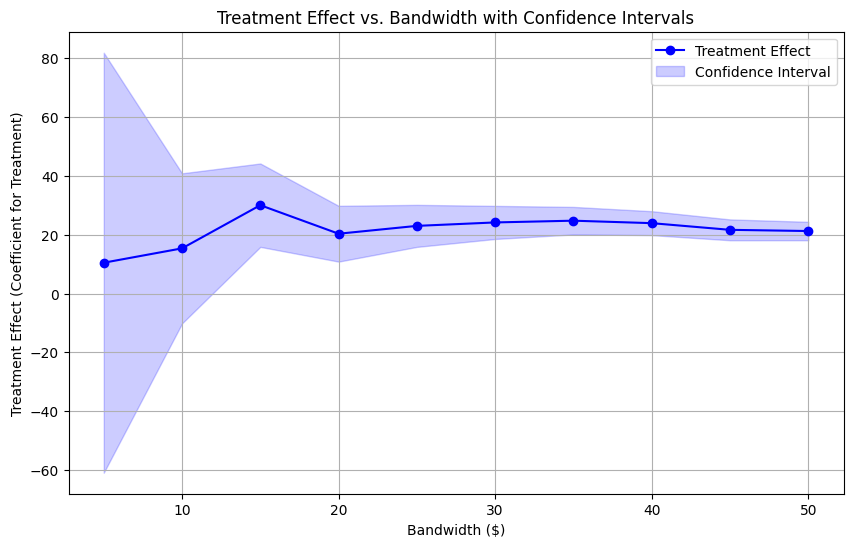

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the treatment effect vs. bandwidth
plt.figure(figsize=(10, 6))
plt.plot(results_df['Bandwidth'], results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
plt.fill_between(results_df['Bandwidth'], results_df['CI_Lower'], results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Treatment Effect (Coefficient for Treatment)')
plt.title('Treatment Effect vs. Bandwidth with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

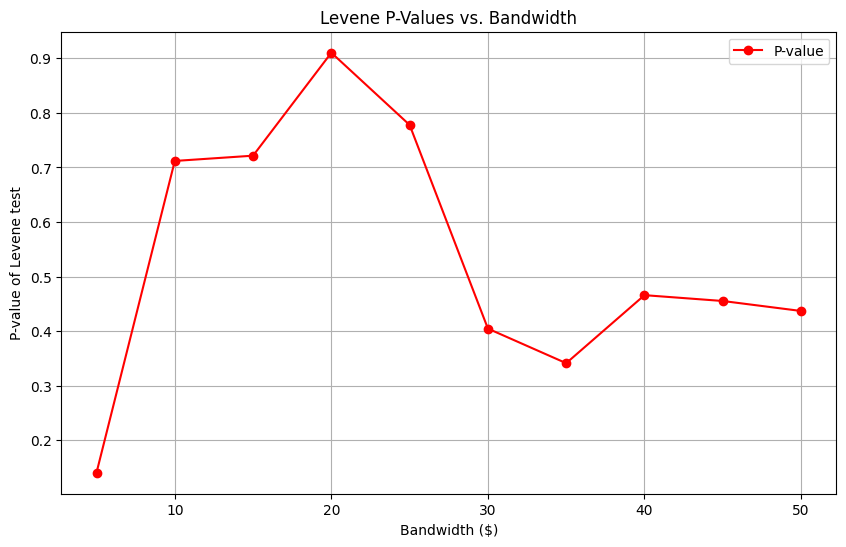

In [20]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(results_df['Bandwidth'], results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.xlabel('Bandwidth ($)')
plt.ylabel('P-value of Levene test')
plt.title('Levene P-Values vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

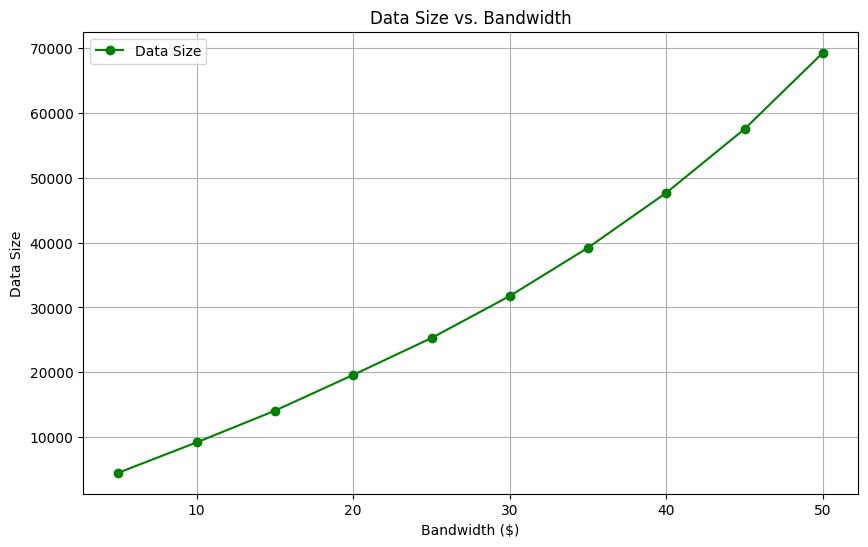

In [22]:
# Plotting the p-value of Levene tests vs. the bandwidth
plt.figure(figsize=(10, 6))
plt.plot(results_df['Bandwidth'], results_df['Data_Size'], label='Data Size', marker='o', color='g')
plt.xlabel('Bandwidth ($)')
plt.ylabel('Data Size')
plt.title('Data Size vs. Bandwidth')
plt.legend()
plt.grid(True)
plt.show()

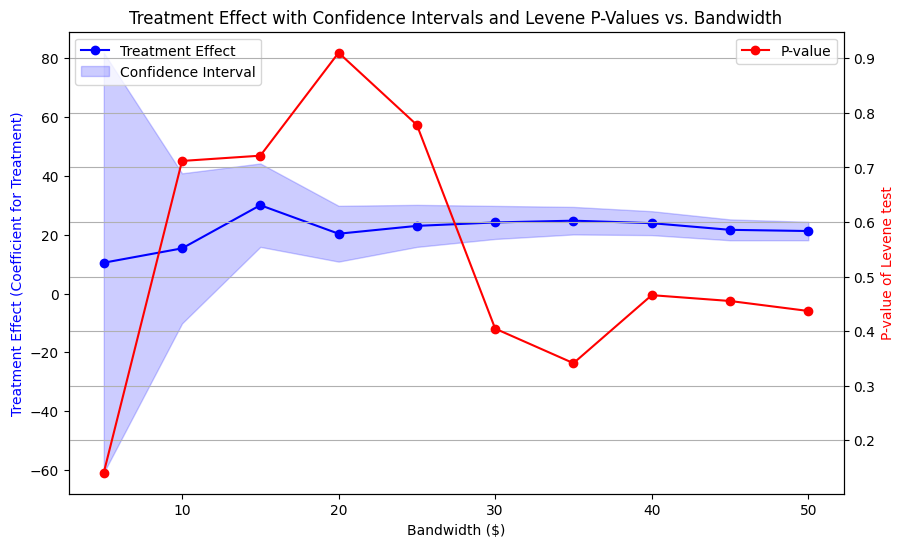

In [32]:
# Plotting the treatment effect & p-value of Levene tests vs. bandwidth

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Bandwidth ($)')

# Plotting treatment effect with CI intervals on the left y-axis
ax1.set_ylabel('Treatment Effect (Coefficient for Treatment)', color='b')
ax1.plot(results_df['Bandwidth'], results_df['Treatment_Effect'], label='Treatment Effect', marker='o', color='b')
ax1.fill_between(results_df['Bandwidth'], results_df['CI_Lower'], results_df['CI_Upper'], color='b', alpha=0.2, label='Confidence Interval')
plt.legend(loc='upper left')

# Plotting the p-value of Levene tests on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-value of Levene test', color='r')
ax2.plot(results_df['Bandwidth'], results_df['Levene_P-Values'], label='P-value', marker='o', color='r')
plt.legend()

plt.title('Treatment Effect with Confidence Intervals and Levene P-Values vs. Bandwidth')
plt.grid(True)
plt.show()